<span style="color: green; font-size: 40px; font-weight: bold;">Projeto 2 (Dados em Tempo Real)</span>

<br><br>

# Análise de Sentimentos sobre o ChatGPT no Twitter

<br><br><br><br>

# <center>Instruções para executar o projeto</center>

> É necessário que a célula da etapa `Criação do Kafka Producer e Envio de Dados para o Kafka` da **Parte 1** do projeto esteja rodando.

<br><br><br>

# Importando Pacotes

<br>

In [2]:
# Imports
import re
import os
import time
import random
import pyspark
import numpy as np
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import Normalizer, StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Análise de Sentimentos
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # Análise de sentimentos baseada em regras

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Eduardo Brandão" --iversions

Author: Eduardo Brandão

pandas    : 1.3.5
seaborn   : 0.11.2
numpy     : 1.22.4
decimal   : 1.70
sys       : 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
matplotlib: 3.4.3
re        : 2.2.1
pyspark   : 3.5.1



<br><br>

# <span style="color: green; font-size: 34px; font-weight: bold;">1. Configuração do Kafka e Spark</span>

In [4]:
# Endereço do servidor Kafka
SERVER = 'localhost:9092'

# Nome do tópico
TOPIC = "Analise_ChatGPT"

# Conectores do Spark para o Apache Kafka
spark_jars =  ("{},{},{},{},{}".format(os.getcwd() + "/jars/novas_versoes/spark-sql-kafka-0-10_2.12-3.5.1.jar",  
                                       os.getcwd() + "/jars/novas_versoes/kafka-clients-3.5.1.jar", 
                                       os.getcwd() + "/jars/novas_versoes/spark-streaming-kafka-0-10-assembly_2.12-3.5.1.jar", 
                                       os.getcwd() + "/jars/novas_versoes/commons-pool2-2.11.0.jar",  
                                       os.getcwd() + "/jars/novas_versoes/spark-token-provider-kafka-0-10_2.12-3.5.1.jar"))

print('Etapa concluída.\n')

Etapa concluída.



In [5]:
import pyspark
print(pyspark.__version__)

3.5.1


**Explicação**: Configura o endereço do servidor Kafka, o nome do tópico, e define os jars necessários para conectar o Spark ao Kafka. Para conectar o Spark Streaming no Apache Kafka precisamos de conectores (`jars`), que estão disponíveis através de arquivos .jar já incluso no projeto.

<br><br><br>

# <span style="color: green; font-size: 34px; font-weight: bold;">2. Inicialização da Sessão Spark</span>

In [6]:
# Inicializa sessão Spark
spark = SparkSession \
        .builder \
        .config("spark.jars", spark_jars) \
        .appName("Analise_de_Sentimentos_Tweet_ChatGPT") \
        .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

print('Etapa concluída.\n')

24/09/23 18:23:57 WARN Utils: Your hostname, eduardo-Inspiron-15-3520 resolves to a loopback address: 127.0.1.1; using 192.168.0.13 instead (on interface wlp0s20f3)
24/09/23 18:23:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/09/23 18:23:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Etapa concluída.



**Explicação**: Inicializa uma sessão Spark com os jars configurados, definindo o nome da aplicação e ajustando o nível de log.

<br><br><br>

# <span style="color: green; font-size: 34px; font-weight: bold;">3. Leitura do Streaming de Dados do Kafka</span>

Esta etapa é para `dados em tempo real`.

In [7]:
# Usamos o Spark Streaming para leitura do streaming de dados do Kafka e salvamos em um dataframe
df = spark \
        .readStream \
        .format("kafka") \
        .option("kafka.bootstrap.servers", SERVER) \
        .option("subscribe", TOPIC) \
        .option("startingOffsets", "latest") \
        .load()

print(df)

print('\nEtapa concluída.')

DataFrame[key: binary, value: binary, topic: string, partition: int, offset: bigint, timestamp: timestamp, timestampType: int]

Etapa concluída.


**Explicação**: Lê o streaming de dados do Kafka, utilizando o Spark Streaming, e armazena em um DataFrame.

#### Explicação mais detalhada:

- **Parte 1**: Na parte 1 do projeto, foi criado um `Kafka Producer que envia mensagens (tweets) para um tópico Kafka (Analise_ChatGPT)`. Cada tweet representa uma mensagem e é enviada para o Kafka em formato de string.

- **Parte 2**: O código na Parte 2, especificamente na seção de "Leitura do Streaming de Dados do Kafka", está utilizando o Spark Streaming para consumir essas mesmas mensagens que foram enviadas para o Kafka.

<br>

**Nota Importante**: Você pode seguir em frente com o projeto enquanto o Kafka Producer ainda está enviando os tweets na `Parte 1`. No entanto, se você prosseguir com o Spark Streaming antes que todas as músicas tenham sido enviadas, o sistema de recomendação funcionará apenas com as músicas que já foram enviadas até aquele momento, e não com o dataset completo. Além disso, não é necessário repetir esse processo de envio todas as vezes que rodar o projeto, a menos que deseje processar novos dados ou reiniciar todo o fluxo.

<br><br><br>

# <span style="color: green; font-size: 34px; font-weight: bold;">4. Processamento e Transformação de Dados</span>

In [8]:
# Selecionamos a coluna timestamp como string e salvamos em um novo dataframe
df1 = df.selectExpr("CAST(value AS STRING)", "timestamp")

print(type(df1))

<class 'pyspark.sql.dataframe.DataFrame'>


**Explicação**:

- **Função**: Esta célula seleciona a coluna `value` do DataFrame `df`, que contém as mensagens do Kafka, e a converte de bytes para string usando o comando `CAST`. Isso é necessário porque as mensagens do Kafka são recebidas como bytes e precisam ser decodificadas para serem manipuladas.
- **Resultado**: O resultado é um novo DataFrame `df1` que contém duas colunas: `value` (convertido para string) e `timestamp` (que registra o momento em que a mensagem foi recebida).

<br>

In [9]:
# Definimos o schema com o nome de cada coluna e o tipo de dado para os tweets
def_schema = "Order_Id INT, Name STRING, Likes DOUBLE, Views DOUBLE, " \
             + "Text STRING, Timestamp STRING"

# Selecionamos o streaming de dados de acordo com o schema e salvamos em um novo dataframe
df2 = df1.select(from_csv(col("value"), def_schema).alias("tweet"), "timestamp")

# Exibindo o novo DataFrame df2
df2

DataFrame[tweet: struct<Order_Id:int,Name:string,Likes:double,Views:double,Text:string,Timestamp:string>, timestamp: timestamp]

**Explicação**:

- **Função**: Primeiro, define o `def_schema`, que especifica o esquema (ou estrutura) dos dados dentro da coluna `value`. Isso inclui os nomes das colunas e seus respectivos tipos de dados.
- **Conversão**: Em seguida, a célula aplica este esquema aos dados da coluna `value` do DataFrame `df1` usando a função `from_csv`. Esta função converte a string `value` em um conjunto de colunas estruturadas de acordo com o esquema definido.
- **Resultado**: O novo DataFrame `df2` possui uma coluna `tweet`, que é uma estrutura (struct) contendo todas as colunas definidas no esquema, além da coluna `timestamp` que foi mantida. 

<br>

In [10]:
# Selecionamos todas as colunas do tweet e renomeamos o 'timestamp' do Kafka para 'Kafka_Read_Timestamp'
df3 = df2.select("tweet.*", col("timestamp").alias("Kafka_Read_Timestamp"))
df3.createOrReplaceTempView("df3_View")

df3.printSchema()

root
 |-- Order_Id: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Likes: double (nullable = true)
 |-- Views: double (nullable = true)
 |-- Text: string (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Kafka_Read_Timestamp: timestamp (nullable = true)



**Explicação**:

- **Função**: Nesta célula, o código desestrutura a coluna song em colunas individuais usando `select`, criando um novo DataFrame `df3` que contém todas as colunas da estrutura `tweet` mais a coluna `timestamp` que foi **renomeada** para `Kafka_Read_Timestamp`.
- **View Temporária**: A célula então cria uma view temporária chamada `df3_View` na memória do Spark, permitindo que você faça consultas SQL diretamente sobre esses dados.
- **Exibição do Schema**: Por fim, a função printSchema exibe a estrutura das colunas e seus tipos de dados no DataFrame `df3`, ajudando a confirmar que os dados foram corretamente transformados e estruturados.

<br>

**Resumo**: Transforma os dados do streaming em colunas estruturadas, define o schema, e cria uma view temporária para consultas SQL.

<br><br><br>

# <span style="color: green; font-size: 34px; font-weight: bold;">5. Consulta e Visualização dos Dados em Tempo Real</span>

<br>

> Nesta seção, você configurará o Spark Streaming para consultar e visualizar os dados em `tempo real à medida que eles chegam do Kafka`.

> Os dados só poderão ser `visualizados caso estejam sendo consumidos em tempo real no script da` **Parte 1** `deste projeto`.

<br>

### 5.1 Seleção dos Dados com os Tweets do Stream

In [11]:
# Selecionamos os dados com as músicas do stream
tweets_stream = spark.sql("SELECT * FROM df3_View")

print('Dados selecionados.')

Dados selecionados.


**Explicação**:

- **Função**: Esta linha executa uma consulta SQL no Spark para selecionar todos os dados da view temporária `df3_View` que foi criada anteriormente.
- **Resultado**: O resultado é um DataFrame chamado `tweets_stream`, que contém todos os dados estruturados dos tweets que foram processadas e armazenadas na view `df3_View`.

<br>

### 5.2 Criação e Configuração do Stream de Dados no Spark Streaming

In [12]:
# Parar todas as consultas de streaming ativas
for stream in spark.streams.active:
    stream.stop()

# Criar o stream de dados no Spark Streaming com modo 'append'
tweets_stream_spark = tweets_stream \
    .writeStream \
    .trigger(processingTime='2 seconds') \
    .outputMode("append") \
    .option("truncate", "false") \
    .format("memory") \
    .queryName("tabela_spark") \
    .start()

print('Processo concluído.\n')

Processo concluído.



**Explicação**:

- **Função Geral**: Este bloco de código configura e inicia um stream de dados usando Spark Streaming, que permite processar dados em tempo real.
- **writeStream**: O método writeStream indica que você está criando um fluxo de saída (stream) a partir do DataFrame `tweets_stream`.
- **trigger(processingTime = '5 seconds')**: Define o intervalo de tempo para processar novos dados. Neste caso, o Spark verificará novos dados a cada 5 segundos e os processará.
- **outputMode("append")**: Especifica que os novos dados serão adicionados ao stream existente sem substituir os dados anteriores. Ou seja, os dados novos são "acrescentados" ao final do stream.
- **option("truncate", "false")**: Esta opção evita que os dados sejam truncados quando exibidos no console ou armazenados na memória. Isso é útil para garantir que você veja todos os dados completos.
- **format("memory")**: Especifica que os dados do stream serão mantidos na memória, permitindo consultas rápidas. Esse é um formato útil para visualização e depuração de dados em tempo real.
- **queryName("tabela_spark")**: Define um nome para a consulta do stream. Isso cria uma tabela temporária chamada tabela_spark que pode ser consultada usando SQL enquanto o stream estiver ativo.
- **start()**: Inicia o stream de dados. A partir deste ponto, o Spark começa a processar e armazenar os dados conforme eles chegam, de acordo com as configurações definidas.

<br>

### 5.3 Espera pela Terminação

In [13]:
#tweets_stream_spark.awaitTermination(2)

**Explicação**:

- **Função**: Este comando faz com que o código aguarde por 2 segundos a execução do stream antes de prosseguir.
- **Uso Prático**: Isso é útil para permitir que o stream processe alguns dados iniciais e, ao mesmo tempo, dar ao desenvolvedor a oportunidade de ver o comportamento do stream de forma controlada.

<br>

### 5.4 Visualizando os Dados

In [31]:
# Selecionamos e Visualizando as músicas da tabela de stream do Spark
spark_tweets = spark.sql("SELECT * FROM tabela_spark")

# Agora sim podemos visualizar o stream em tempo real como tabela do Spark
spark_tweets.show()

+--------+--------------------+------+--------+--------------------+--------------------+--------------------+
|Order_Id|                Name| Likes|   Views|                Text|           Timestamp|Kafka_Read_Timestamp|
+--------+--------------------+------+--------+--------------------+--------------------+--------------------+
|       5|          SummerTime|  49.0|  1000.0|chatgpt magic int...|2024-09-12T01:21:...|2024-09-23 18:24:...|
|       7|        Parul Gautam|  91.0| 25000.0|3 create review v...|2024-09-14T13:53:...|2024-09-23 18:24:...|
|       8|         Poonam Soni|  74.0| 21000.0|5 create art chat...|2024-09-14T12:32:...|2024-09-23 18:24:...|
|       9|        Arsalan Khan| 114.0| 15000.0|chatgpt prompts c...|2024-09-12T06:02:...|2024-09-23 18:24:...|
|      10|  Benjamin De Kraker| 334.0|104000.0|seen post claimin...|2024-09-16T07:47:...|2024-09-23 18:24:...|
|      11|              Nonini| 305.0| 13000.0|hi good people ch...|2024-09-11T16:44:...|2024-09-23 18:24:...|
|

In [32]:
# Contagem de músicas extraídas em tempo real
spark_tweets.count()

47

**Explicação**: Se o valor acima for **zero** significa que não estamos consumindo dados em tempo real no momento.

<br><br><br>

# <span style="color: green; font-size: 34px; font-weight: bold;">6. Consulta e Visualização dos Dados em Modo Batch</span>

> **Importante**: A `etapa 6` realiza as `etapas 3 e 4 em uma única célula`, pois combina a leitura dos dados do Kafka em modo batch (semelhante ao que é feito na etapa 5, que usa o Spark Streaming para ler os dados em tempo real) com o processamento e transformação dos dados (que foi feito na etapa 4 para estruturar e aplicar um schema).

> Nesta seção, você configurará a leitura dos dados do Kafka em `modo batch, o que significa que todos os dados desde o início até o último offset disponível no Kafka serão lidos de uma vez`.

<br>

In [33]:
# Verificando
if spark_tweets.count() == 0:
    print("\nO DataFrame `spark_tweets` está vazio. Vamos carregar os dados em modo batch.\n")
    
    # Configuração para leitura dos dados do Kafka em modo batch
    df_batch = spark \
        .read \
        .format("kafka") \
        .option("kafka.bootstrap.servers", SERVER) \
        .option("subscribe", TOPIC) \
        .option("startingOffsets", "earliest") \
        .option("endingOffsets", "latest") \
        .load()

    # Converte os dados do Kafka (em bytes) para string e aplica o schema
    df1_batch = df_batch.selectExpr("CAST(value AS STRING)", "timestamp")

    # Aplica o schema que você definiu anteriormente na etapa 4
    df2_batch = df1_batch.select(from_csv(col("value"), def_schema).alias("tweet"), "timestamp")

    # Seleciona as colunas estruturadas para visualizar
    spark_tweets = df2_batch.select("tweet.*", "timestamp")

    # Visualiza os dados
    spark_tweets.show(5, truncate=False)
else:
    print("\nO DataFrame `spark_tweets` tem dados.\n")


O DataFrame `spark_tweets` tem dados.



In [34]:
# Exibe o nome das colunas do DataFrame `spark_songs`
print("Colunas de `spark_tweets`:")
print(spark_tweets.columns)

Colunas de `spark_tweets`:
['Order_Id', 'Name', 'Likes', 'Views', 'Text', 'Timestamp', 'Kafka_Read_Timestamp']


In [35]:
# Conta o número de linhas no DataFrame `spark_tweets`
num_linhas = spark_tweets.count()

# Exibe a quantidade de linhas
print(f"O DataFrame `spark_tweets` contém {num_linhas} linhas.")

O DataFrame `spark_tweets` contém 47 linhas.


<br><br><br>

# <span style="color: green; font-size: 34px; font-weight: bold;">7. Análise Exploratória Inicial dos Dados</span>

<br>

### Criação de Função Para Análise Inicial

In [36]:
def funcao_analise_inicial(df):
    # Exibir o esquema do DataFrame
    print("\n\n INFO \n\n")
    df.printSchema()

    # Número total de registros
    print(f"\nNúmero total de registros: {df.count()}")
    
    # Verificar valores ausentes (ajustando para usar isnan apenas em colunas numéricas)
    print("\n\nVerificando valores ausentes:\n")
    
    # Lista para armazenar expressões de verificação de valores ausentes
    checks = []
    
    for coluna, tipo in df.dtypes:
        if tipo in ["double", "float"]:  # isnan aplicado apenas a colunas numéricas
            checks.append(count(when(col(coluna).isNull() | isnan(col(coluna)), coluna)).alias(coluna))
        else:  # isNull aplicado a outros tipos de colunas
            checks.append(count(when(col(coluna).isNull(), coluna)).alias(coluna))
    
    # Verifica e exibe valores ausentes
    df_ausentes = df.select(checks)
    df_ausentes.show()

    # Verificar valores duplicados
    num_linhas_duplicadas = df.count() - df.dropDuplicates().count()
    porcentagem_linhas_duplicadas = (num_linhas_duplicadas / df.count()) * 100
    print(f"\n\nExistem valores duplicados: {num_linhas_duplicadas > 0}")
    if num_linhas_duplicadas > 0:
        print(f"Número de Linhas Duplicadas: {num_linhas_duplicadas}")
        print(f"Porcentagem de Linhas Duplicadas: {porcentagem_linhas_duplicadas:.2f}%")
    else:
        print("Nenhuma variável possui valores duplicados.")

    # Verificação de caracteres especiais
    caracteres_especiais = re.compile('[@_!#$%^&*<>()?/\\|}{~:]')
    colunas_com_caracteres_especiais = {}

    # Iterar sobre colunas do tipo string
    for coluna in df.columns:
        if dict(df.dtypes)[coluna] == 'string':
            contem_caracteres_especiais = df.filter(df[coluna].rlike('[@_!#$%^&*<>()?/\\|}{~:]')).count() > 0
            if contem_caracteres_especiais:
                indices_com_caracteres_especiais = df.filter(df[coluna].rlike('[@_!#$%^&*<>()?/\\|}{~:]')).select(coluna).rdd.map(lambda row: row[coluna]).collect()
                colunas_com_caracteres_especiais[coluna] = indices_com_caracteres_especiais

    # Exibe o resultado sobre caracteres especiais
    print("\n\nExistem caracteres especiais nas colunas:", bool(colunas_com_caracteres_especiais))
    if colunas_com_caracteres_especiais:
        print("\nColunas com caracteres especiais:")
        for coluna, indices in colunas_com_caracteres_especiais.items():
            print(f"\n Coluna [ {coluna} ]")
    else:
        print("\nNenhuma coluna possui caracteres especiais.")

print('A função foi criada com sucesso.\n\n')

A função foi criada com sucesso.




In [37]:
# Chama a Função Analise inicial
funcao_analise_inicial(spark_tweets)



 INFO 


root
 |-- Order_Id: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Likes: double (nullable = true)
 |-- Views: double (nullable = true)
 |-- Text: string (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Kafka_Read_Timestamp: timestamp (nullable = true)


Número total de registros: 47


Verificando valores ausentes:

+--------+----+-----+-----+----+---------+--------------------+
|Order_Id|Name|Likes|Views|Text|Timestamp|Kafka_Read_Timestamp|
+--------+----+-----+-----+----+---------+--------------------+
|       0|   0|    0|    0|   0|        0|                   0|
+--------+----+-----+-----+----+---------+--------------------+



Existem valores duplicados: False
Nenhuma variável possui valores duplicados.


Existem caracteres especiais nas colunas: True

Colunas com caracteres especiais:

 Coluna [ Name ]

 Coluna [ Timestamp ]


<br><br><br>

# <span style="color: green; font-size: 34px; font-weight: bold;">8. Aplicar Análise de Sentimentos com VADER</span>

<br>

#### Criando e Aplicando Função Para Aplicar a Análise de Sentimentos em Cada Tweet

In [38]:
# Inicializar o analisador de sentimentos VADER
analyzer = SentimentIntensityAnalyzer()

# Função para aplicar a análise de sentimentos em cada tweet
def apply_vader(text):
    """
    Recebe o texto de um tweet, calcula a pontuação de sentimento usando VADER
    e retorna a classificação (positivo, neutro ou negativo).
    """
    scores = analyzer.polarity_scores(text)  # Obter as pontuações de sentimento
    compound = scores['compound']            # O "compound" é a pontuação geral de sentimento
    
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Criar uma UDF (User Defined Function) para aplicar o VADER ao PySpark
vader_udf = udf(apply_vader, StringType())

# Aplicar a função de análise de sentimentos ao DataFrame Spark
spark_tweets = spark_tweets.withColumn("Sentiment", vader_udf(spark_tweets["Text"]))

# Verificar as primeiras linhas para confirmar a nova coluna
spark_tweets.show()

+--------+--------------------+------+--------+--------------------+--------------------+--------------------+---------+
|Order_Id|                Name| Likes|   Views|                Text|           Timestamp|Kafka_Read_Timestamp|Sentiment|
+--------+--------------------+------+--------+--------------------+--------------------+--------------------+---------+
|       5|          SummerTime|  49.0|  1000.0|chatgpt magic int...|2024-09-12T01:21:...|2024-09-23 18:24:...| Positive|
|       7|        Parul Gautam|  91.0| 25000.0|3 create review v...|2024-09-14T13:53:...|2024-09-23 18:24:...| Positive|
|       8|         Poonam Soni|  74.0| 21000.0|5 create art chat...|2024-09-14T12:32:...|2024-09-23 18:24:...| Positive|
|       9|        Arsalan Khan| 114.0| 15000.0|chatgpt prompts c...|2024-09-12T06:02:...|2024-09-23 18:24:...| Negative|
|      10|  Benjamin De Kraker| 334.0|104000.0|seen post claimin...|2024-09-16T07:47:...|2024-09-23 18:24:...| Negative|
|      11|              Nonini| 

<br><br><br>

# <span style="color: green; font-size: 34px; font-weight: bold;">9. Visualização dos Resultados</span>

<br>

#### Criando Objeto Para Usar nos Gráficos

In [39]:
# Contar a quantidade de tweets por tipo de sentimento
sentiment_counts = spark_tweets.groupBy("Sentiment").count().orderBy("count", ascending=False)

# Coletar os resultados para visualização em gráfico
sentiment_counts_pandas = sentiment_counts.toPandas()

print('Etapa concluída.')

Etapa concluída.


<br>

#### Visualizando por Gráfico de Barras

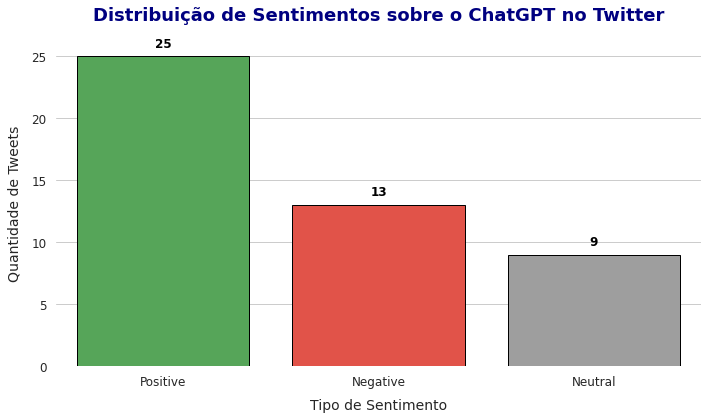

In [40]:
# Configurações globais de estilo para o gráfico
sns.set_theme(style="whitegrid", palette="deep")

# Definir cores específicas para cada sentimento
custom_palette = {
    'Positive': '#4CAF50',  # Verde para positivo
    'Negative': '#F44336',  # Vermelho para negativo
    'Neutral': '#9E9E9E'    # Cinza para neutro
}

# Tamanho do gráfico
plt.figure(figsize=(10,6))

# Plotar o gráfico de barras com cores personalizadas
ax = sns.barplot(
    x=sentiment_counts_pandas['Sentiment'], 
    y=sentiment_counts_pandas['count'], 
    palette=custom_palette,  # Aplicar a paleta de cores personalizada
    edgecolor='black',
    saturation=0.8
)

# Adicionar os valores no topo de cada barra
for index, value in enumerate(sentiment_counts_pandas['count']):
    ax.text(index, value + 0.5, f'{value:,}', ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Melhorando a estética do gráfico
plt.title('Distribuição de Sentimentos sobre o ChatGPT no Twitter', fontsize=18, fontweight='bold', color='navy', pad=20)
plt.xlabel('Tipo de Sentimento', fontsize=14, labelpad=10)
plt.ylabel('Quantidade de Tweets', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Removendo bordas desnecessárias
sns.despine(left=True, bottom=True)

# Ajustando espaçamento para que o gráfico não fique muito apertado
plt.tight_layout()

# Mostrar o gráfico
plt.show()

<br>

#### Visualizando por Gráfico de Linha (Line Plot) ao Longo do Tempo Gráfico de Barras

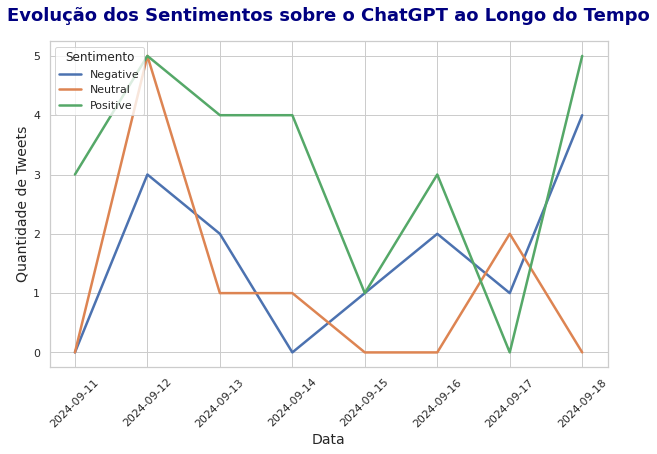

In [41]:
# Convertendo a coluna Timestamp para formato de data
spark_tweets_pandas = spark_tweets.toPandas()
spark_tweets_pandas['Date'] = pd.to_datetime(spark_tweets_pandas['Timestamp']).dt.date

# Contar o número de tweets por dia e por tipo de sentimento
tweets_por_dia = spark_tweets_pandas.groupby(['Date', 'Sentiment']).size().unstack().fillna(0)

# Plotar gráfico de linha para evolução dos sentimentos ao longo do tempo
tweets_por_dia.plot(kind='line', figsize=(10, 6), linewidth=2.5)
plt.title('Evolução dos Sentimentos sobre o ChatGPT ao Longo do Tempo', fontsize=18, fontweight='bold', color='navy', pad=20)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Quantidade de Tweets', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Sentimento', loc='upper left')
plt.grid(True)
plt.show()

<br>

#### Visualizando por Gráfico de Histograma

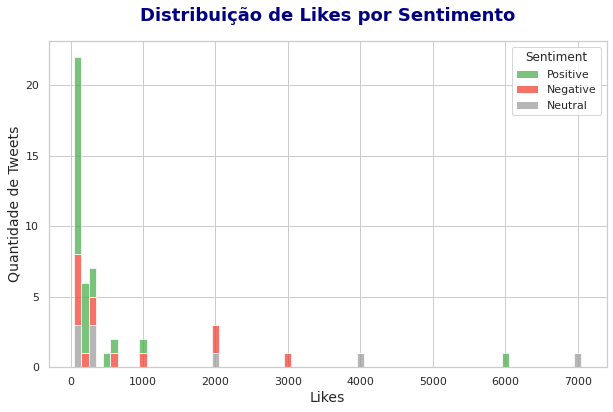

In [42]:
# Plotar histogramas para quantidade de Likes e Views por sentimento
plt.figure(figsize=(10, 6))
sns.histplot(data=spark_tweets_pandas, x='Likes', hue='Sentiment', multiple='stack', palette=custom_palette, binwidth=100)
plt.title('Distribuição de Likes por Sentimento', fontsize=18, fontweight='bold', color='navy', pad=20)
plt.xlabel('Likes', fontsize=14)
plt.ylabel('Quantidade de Tweets', fontsize=14)
plt.show()

<br>

#### Visualizando por Gráfico de Dispersão (Scatter Plot)

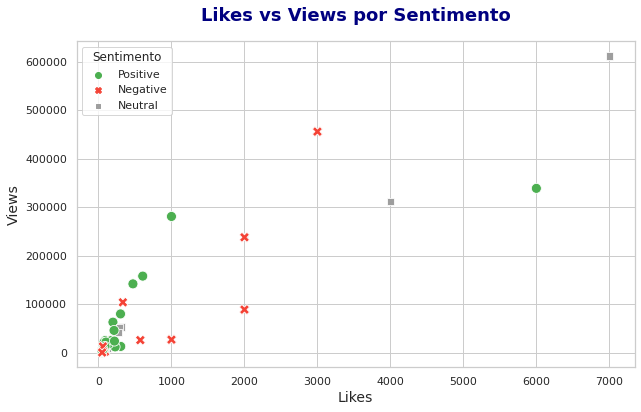

In [43]:
# Gráfico de dispersão Likes vs Views por sentimento
plt.figure(figsize=(10, 6))
sns.scatterplot(data=spark_tweets_pandas, x='Likes', y='Views', hue='Sentiment', style='Sentiment', palette=custom_palette, s=100)
plt.title('Likes vs Views por Sentimento', fontsize=18, fontweight='bold', color='navy', pad=20)
plt.xlabel('Likes', fontsize=14)
plt.ylabel('Views', fontsize=14)
plt.legend(title='Sentimento')
plt.grid(True)
plt.show()

<br><br><br>

# <span style="color: green; font-size: 34px; font-weight: bold;">6. Conclusão</span>

<br>

#### Exibindo os Resultados

In [44]:
# Exibir a contagem dos tipos de sentimentos
print("\nContagem dos Sentimentos:")
sentiment_counts.show()

# Conclusão sobre o sentimento predominante
sentimento_predominante = sentiment_counts.orderBy("count", ascending=False).first()["Sentiment"]
print(f"\nO sentimento predominante sobre o ChatGPT é: {sentimento_predominante.capitalize()}")

# Calcular a porcentagem de tweets para cada sentimento
total_tweets = spark_tweets.count()
sentiment_percentage = sentiment_counts.withColumn("percentage", (sentiment_counts["count"] / total_tweets) * 100)

# Exibir a porcentagem de cada sentimento
print("\n\nPorcentagem de cada sentimento:")
sentiment_percentage.show()


Contagem dos Sentimentos:
+---------+-----+
|Sentiment|count|
+---------+-----+
| Positive|   25|
| Negative|   13|
|  Neutral|   10|
+---------+-----+


O sentimento predominante sobre o ChatGPT é: Positive


Porcentagem de cada sentimento:
+---------+-----+------------------+
|Sentiment|count|        percentage|
+---------+-----+------------------+
| Positive|   25|52.083333333333336|
| Negative|   13|27.083333333333332|
|  Neutral|   10|20.833333333333336|
+---------+-----+------------------+



<br><br><br>

# <span style="color: green; font-size: 34px; font-weight: bold;">6. Salvando os Resultados</span>

<br>

#### Salvando no PC

In [45]:
# Converter os DataFrames PySpark para Pandas
spark_tweets_pandas = spark_tweets.toPandas()
sentiment_counts_pandas = sentiment_counts.toPandas()

# Defina o caminho da pasta onde deseja salvar os arquivos
output_folder = "resultados/"

# Salvar o DataFrame df_english como CSV
spark_tweets_pandas.to_csv(f"{output_folder}/tweets_sentiment_analysis_real_time_analytics.csv", index=False)

# Salvar o DataFrame sentiment_counts como CSV
sentiment_counts_pandas.to_csv(f"{output_folder}/sentiment_counts_real_time_analytics.csv", index=False)

# Salvar o DataFrame sentiment_percentage como CSV
sentiment_percentage_pandas = sentiment_percentage.toPandas()
sentiment_percentage_pandas.to_csv(f"{output_folder}/sentiment_percentage_real_time_analytics.csv", index=False)

print('Todos os arquivos foram salvos com sucesso.\n')

Todos os arquivos foram salvos com sucesso.



<br>

# Fim!